In [1]:
pip install lightgbm

Note: you may need to restart the kernel to use updated packages.


In [1]:
import numpy as np
import pandas as pd 
from matplotlib import pyplot as plt
import seaborn as sns
import lightgbm as lgb
import warnings

In [112]:
buildingdata = pd.read_csv('/Users/New/Desktop/building0.csv')

In [15]:
buildingdata=buildingdata[:len(buildingdata)//10]

In [113]:
buildingdata.tail()

,X,series_name,start_timestamp,TimeDate,Date,Year,Season,Month,Day_of_Month,Day,Week,Hour,Minute,series_value
101401,148806,Building0,1/10/2020 8:45,1/10/2020 8:45,1/10/2020,2020,4,Oct,1,4,40,8,45,96.9
101402,148807,Building0,1/10/2020 9:00,1/10/2020 9:00,1/10/2020,2020,4,Oct,1,4,40,9,0,96.9
101403,148808,Building0,1/10/2020 9:15,1/10/2020 9:15,1/10/2020,2020,4,Oct,1,4,40,9,15,37.4
101404,148809,Building0,1/10/2020 9:30,1/10/2020 9:30,1/10/2020,2020,4,Oct,1,4,40,9,30,37.4
101405,148810,Building0,1/10/2020 9:45,1/10/2020 9:45,1/10/2020,2020,4,Oct,1,4,40,9,45,37.4


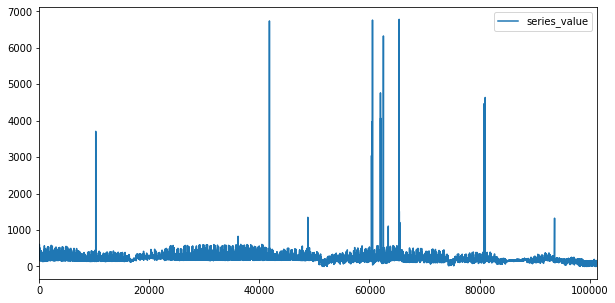

In [114]:
plt.rcParams['figure.figsize'] = [10, 5]

buildingdata['series_value'].plot()
plt.legend()
plt.show()

In [55]:
buildingdata.tail()

,X,series_name,start_timestamp,TimeDate,Date,Year,Season,Month,Day_of_Month,Day,Week,Hour,Minute,series_value
10135,10136,Building0,17/10/2016 22:15,17/10/2016 22:15,17/10/2016,2016,4,Oct,17,1,42,22,15,358.8
10136,10137,Building0,17/10/2016 22:30,17/10/2016 22:30,17/10/2016,2016,4,Oct,17,1,42,22,30,358.8
10137,10138,Building0,17/10/2016 22:45,17/10/2016 22:45,17/10/2016,2016,4,Oct,17,1,42,22,45,358.8
10138,10139,Building0,17/10/2016 23:00,17/10/2016 23:00,17/10/2016,2016,4,Oct,17,1,42,23,0,358.8
10139,10140,Building0,17/10/2016 23:15,17/10/2016 23:15,17/10/2016,2016,4,Oct,17,1,42,23,15,273.8


In [6]:
#Testing 

In [115]:
#Creating X Y 
def create_xy(series, window_size, prediction_horizon, shuffle = False):
    x = []
    y = []
    for i in range(0, len(series)):
        if len(series[(i + window_size):(i + window_size + prediction_horizon)]) < prediction_horizon:
            break
        x.append(series[i:(i + window_size)])
        y.append(series[(i + window_size):(i + window_size + prediction_horizon)])
    x = np.array(x)
    y = np.array(y)
    return x,y

In [ ]:
#Hyperparameters
window_size = 10000
prediction_horizon = 1

#Train Test Split
test_size = 1000
split = len(buildingdata['series_value']) - test_size

train_series = buildingdata['series_value'][:split]
test_series = buildingdata['series_value'][split-window_size:]


train_x, train_y = create_xy(train_series.to_numpy(), window_size, prediction_horizon)
test_x, test_y = create_xy(test_series.to_numpy(), window_size, prediction_horizon)

train_y = train_y.flatten()
test_y = test_y.flatten()

print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

In [ ]:
plt.rcParams['figure.figsize'] = [10, 5]

buildingdata['series_value'][-test_size:].plot(label = 'Building 0 Test')
plt.legend()
plt.show()

In [ ]:
#Tbh don't know much about lightgbm parameters enough to mess around yet
import lightgbm as lgb
"""
params = {
    'n_estimators': 2000,
    'max_depth': 4,
    'num_leaves': 2**4,
    'learning_rate': 0.1,
    'boosting_type': 'dart'
}
"""
model = lgb.LGBMRegressor(first_metric_only = True)

model.fit(train_x, train_y,
          eval_metric = 'l1', 
          eval_set = [(test_x, test_y)],
          early_stopping_rounds = 10,
          verbose = 0)

     Naive MAE: 3.8292
  s2-Naive MAE: 58.7252
 s3-Naive MAE: 79.1384
s4-Naive MAE: 52.4820
s5-Naive MAE: 21.3224
  LightGBM MAE: 6.9518


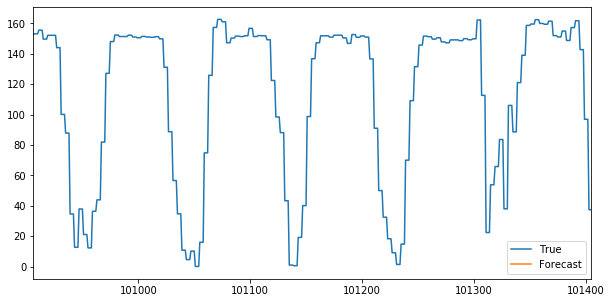

In [121]:
forecast = model.predict(test_x)
s1_naive = buildingdata['series_value'][-501:-1].to_numpy()
s2_naive = buildingdata['series_value'][-1001:-501].to_numpy()
s3_naive = buildingdata['series_value'][-1501:-1001].to_numpy()
s4_naive = buildingdata['series_value'][-2001:-1501].to_numpy()
s5_naive = buildingdata['series_value'][-2501:-2001].to_numpy()

print('     Naive MAE: %.4f' % (np.mean(np.abs(s1_naive - test_y))))
print('  s2-Naive MAE: %.4f' % (np.mean(np.abs(s2_naive - test_y))))
print(' s3-Naive MAE: %.4f' % (np.mean(np.abs(s3_naive - test_y))))
print('s4-Naive MAE: %.4f' % (np.mean(np.abs(s4_naive - test_y))))
print('s5-Naive MAE: %.4f' % (np.mean(np.abs(s5_naive - test_y))))
print('  LightGBM MAE: %.4f' % (np.mean(np.abs(forecast - test_y))))

plt.rcParams['figure.figsize'] = [10, 5]

buildingdata['series_value'][-test_size:].plot(label = 'True')
plt.plot(forecast, label = 'Forecast')
plt.legend()
plt.show()

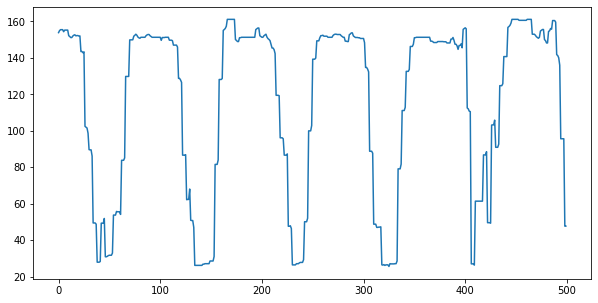

In [120]:
plt.plot(forecast, label = 'Forecast')